<a href="https://www.kaggle.com/code/carolinariddick/signaldenoiser-with-matlab?scriptVersionId=273214505" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# <span style="color:rgb(213,80,0)">Denoise Signals with Adversarial Learning Denoiser Model</span>

This example shows how to denoise noisy signals using an adversarial learning denoiser model [\[1\].](#M_ED167CE9) The model is wrapped as an object that can be trained with any data set of real 1\-D signals. After training, the object is ready to denoise test signals that have similar characteristics as those in the training set. This example shows the efficacy of the model on noisy electrocardiogram (ECG) and electroencephalogram (EEG) signals. Denoising these types of signals is a challenging problem because they are nonstationary and have spectral content of interest that overlaps with the noise spectrum. In the example, after you denoise the signals using the adversarial learning model, you compare the results to those of a conventional wavelet denoising technique and of an LSTM network denoiser model.

https://es.mathworks.com/help/deeplearning/ug/signal-denoising-using-adversarial-learning-denoiser-model.html?searchHighlight=eeg&s_tid=srchtitle_support_results_8_eeghttps%3A%2F%2Fwww.mathworks.com%2Fhelp%2Fwavelet%2Fug%2Ftime-frequency-convolutional-network-for-eeg-data-classification.html%3FsearchHighlight%3Deeg&s_tid=srchtitle_support_results_3_eeg

## Adversarial Learning Denoiser Model

Adversarial learning and generative adversarial networks (GANs) have been widely used in image generation and are now applied to other fields, including signal processing. Adversarial models involve two main components: a generator that generates data that attempts to fool the discriminator and a discriminator that distinguishes between artificially generated data and real data.


In this example, you train an adversarial learning model using clean and noisy signals. The model acts as a signal denoiser and has this learning architecture.

<p style="text-align:left">
   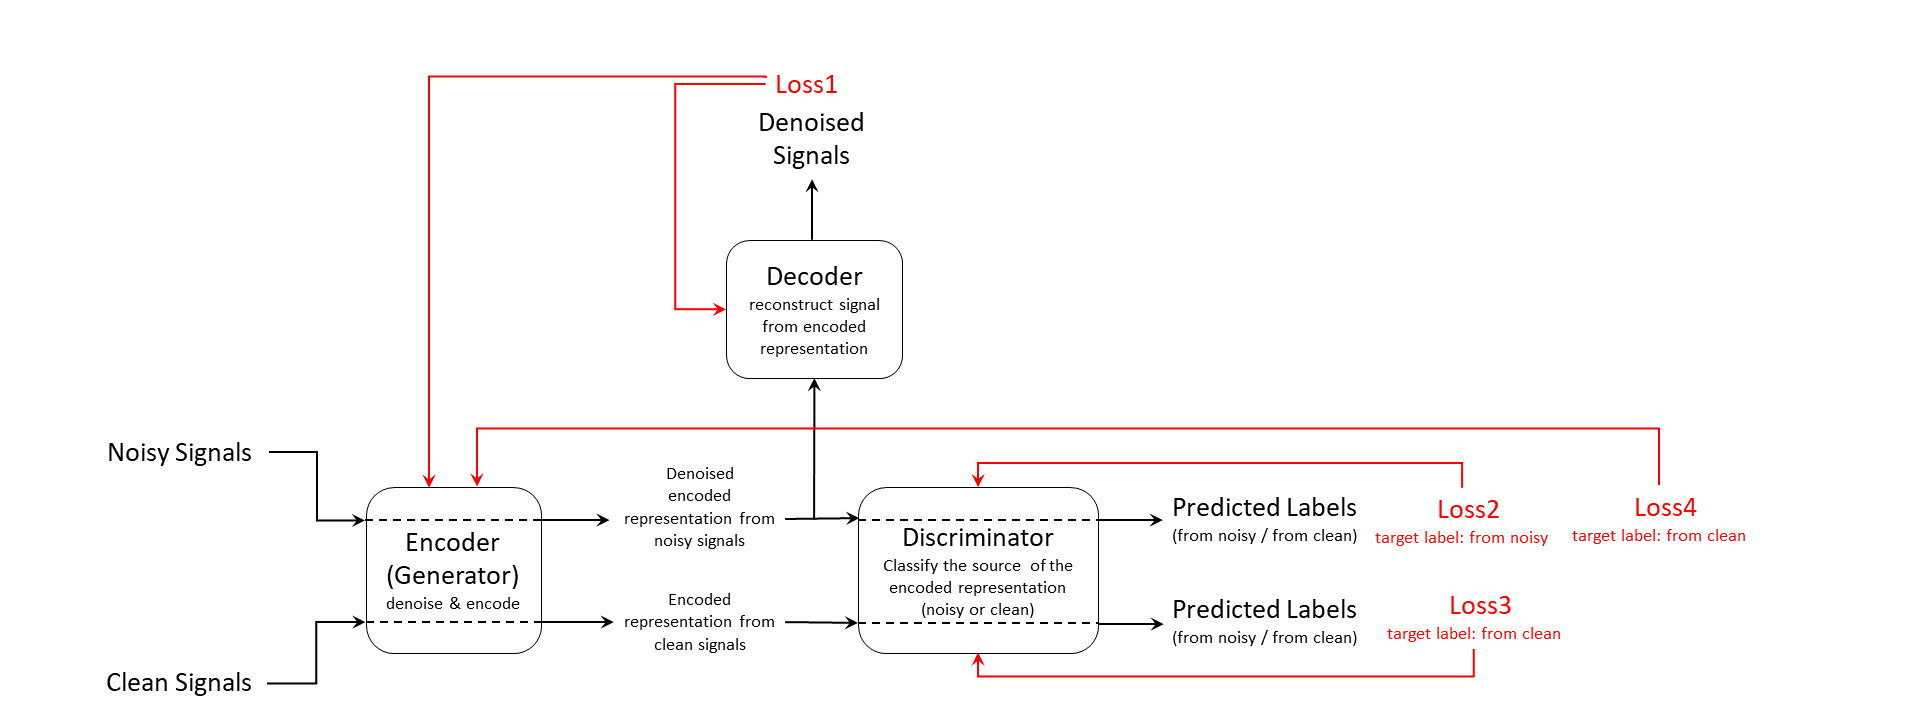
</p>


The training input data consists of a set of signals including both clean and noisy realizations. The *encoder*, which is also the generator, generates an encoded latent representation of the input signals. Ideally, the encoded representation meets these two requirements:

1.  The representation does not encode any noise information and be clean enough to fool the discriminator into thinking it was encoded from a clean input signal.
2. The representation encodes enough information for the decoder to reconstruct the original signal from it.

The discriminator is responsible for identifying whether the latent representation comes from a clean input signal or a noisy one. Finally, the decoder reconstructs the denoised signal from the latent representation. The discriminator and decoder both provide feedback in the form of computed loss values. The system uses that feedback to update the encoder, the discriminator, and the decoder.


**Loss1** is the mean squared error (MSE) between the generated denoised signal and the clean input signal. **Loss2**, **Loss3**, and **Loss4** are all cross\-entropy losses for predicted labels from the discriminator. The model use noisy source signal training set to compute **Loss2** and **Loss4** and clean source signal training set to compute **Loss3**.


Because the encoder wants to fool the discriminator, the target label for **Loss4** is clean even though it is always computed using noisy signal inputs.

## Data Preparation

This example uses the Physionet ECG\-ID database [\[2\]](#M_E2B4ED49) [\[3\]](#M_5B899A74), which has 310 ECG records from 90 subjects. Each record contains a raw noisy ECG signal and a manually filtered clean ground truth version.


Save the data set to a local folder or download the data use the following code.


In [1]:
datasetFolder = fullfile(tempdir,"ecg-id-database-1.0.0");
if ~isfolder(datasetFolder)
    loc = websave(tempdir,"https://physionet.org/static/published-projects/ecgiddb/ecg-id-database-1.0.0.zip");
    unzip(loc,tempdir);
end


Create a [`signalDatastore`](<docid:signal_ref#mw_e8c00dd4-46da-49c5-9a81-f540e9ac71ea>) object to manage the data. Randomly select data from 10 different subjects as the test set. Reset the random seed so that reproducible data segmentation and visualization results are reproducible.


In [2]:
sds = signalDatastore(datasetFolder, ...
                      IncludeSubfolders = true, ...
                      FileExtensions = ".dat", ...
                      ReadFcn = @helperReadSignalData);
rng("default")

subjectIds = unique(extract(sds.Files,"Person_"+digitsPattern));
testSubjects = contains(sds.Files,subjectIds(randperm(numel(subjectIds),10)));
testDs = subset(sds,testSubjects);


Use 80% of the remaining data for training and 20% for validation.


In [3]:
trainAndValDs = subset(sds,~testSubjects);
trainAndValDs = shuffle(trainAndValDs);
[trainInd,valInd] = dividerand(1:numel(trainAndValDs.Files),0.8,0.2,0);
trainDs = subset(trainAndValDs,trainInd);
validDs = subset(trainAndValDs,valInd);

## Train Adversarial Signal Denoiser Object

Create a signal denoiser object for later use in training and denoising. Because the model is dependent on the signal length, the object can work only with fixed\-length signals. Specify the signal length when creating the model.


In [4]:
sampleSignal = preview(trainDs);
signalLength = length(sampleSignal{1});
advDenoiser = helperAdversarialSignalDenoiser(signalLength);


Use the `train` function to train the denoiser object. You can specify multiple training options by passing extra optional argument inputs to customize the training process.


Set the `doTrain` flag to false if you want to skip the training process and directly load a pretrained object.


Training loss after epoch 1: 1.7162
Training loss after epoch 10: 0.011477
Training loss after epoch 20: 0.018192
Training loss after epoch 30: 0.0096357
Training loss after epoch 40: 0.044912
Training loss after epoch 50: 0.003166
Training loss after epoch 60: 0.060249
Training loss after epoch 70: 0.0038481
Training loss after epoch 80: 0.0061918
Training loss after epoch 90: 0.0021122
Training loss after epoch 100: 0.001513


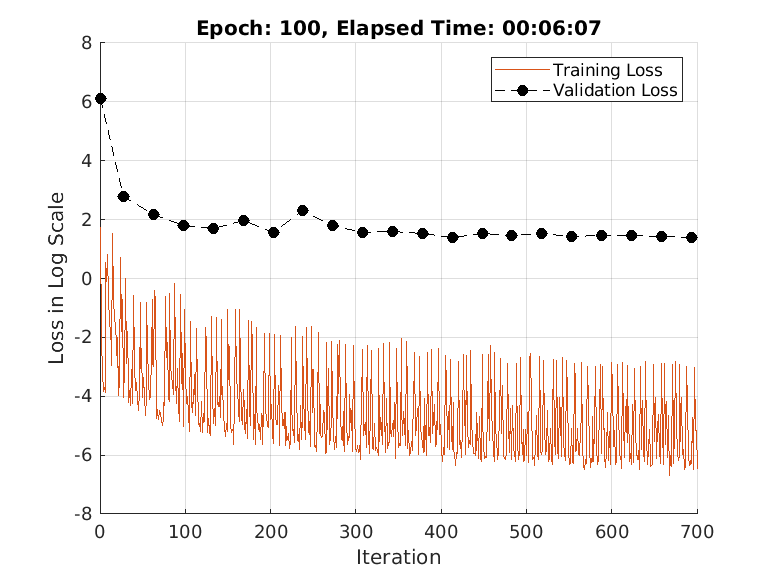

In [5]:
doTrain = true;
if doTrain
    train(advDenoiser,trainDs,...
        ValidationData = validDs, ...
        MaxEpochs = 100, ...
        MiniBatchSize = 32, ...
        Plots = true, ...
        Normalization = true);
else
    zipFile = matlab.internal.examples.downloadSupportFile('SPT','data/adversarialLearningDenoiserModelParameters.zip');
    unzip(zipFile);
    loadParameters(advDenoiser,"adversarialLearningDenoiserModelParameters");
end

## Denoise Signals on Test Data Set

Use `denoise` to test the denoiser object with the signal data in the test signal datastore `testDs`. You can specify the batch size and execution environment that the `denoise` function uses. Note that the output of the `denoise` function is also a datastore.


In [6]:
denoisedSignalsDs = denoise(advDenoiser,testDs, ...
    "MiniBatchSize",32, ...
    "ExecutionEnvironment","auto");


Get the clean signals, noisy signals, and denoised signals from the datastores and store them as row\-wise matrices.


In [7]:
testData = readall(testDs);
denoisedSignals = readall(denoisedSignalsDs);
denoisedSignals = cat(1,denoisedSignals{:});

noisySignals = cellfun(@(x) x(1),testData);
noisySignals = cat(1,noisySignals{:});

cleanSignals = cellfun(@(x) x(2),testData);
cleanSignals = cat(1,cleanSignals{:});


Compare the original and the denoised signal\-to\-noise ratio (SNR) values.



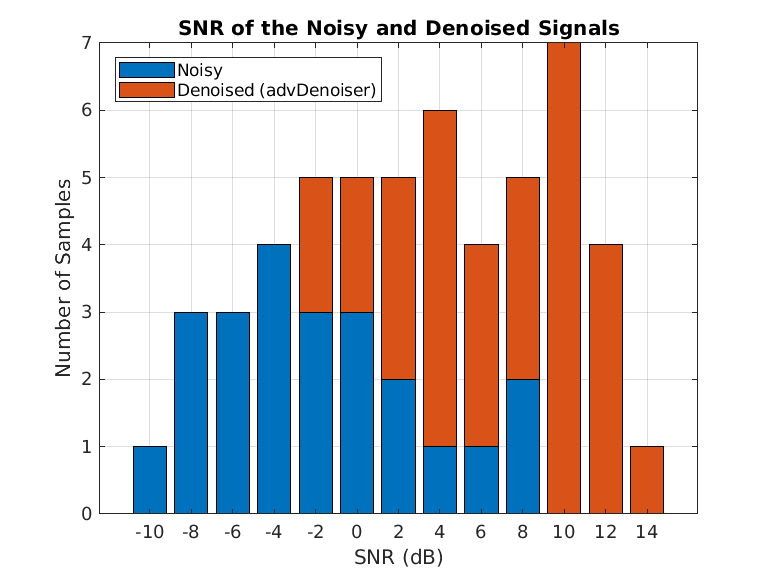

In [8]:
N = size(cleanSignals,1);
snrsNoisy = zeros(N,1);
snrsDenoised = zeros(N,1);
snrsWaveletDenoised = zeros(N,1);
for i = 1:N
    snrsNoisy(i) = snr(cleanSignals(i,:),cleanSignals(i,:)-noisySignals(i,:));
end
for i = 1:N
    snrsDenoised(i) = snr(cleanSignals(i,:),cleanSignals(i,:)-denoisedSignals(i,:));
end

SNRs = [snrsNoisy,snrsDenoised];

bins = -10:2:16;
count = zeros(2,length(bins)-1);
for i =1:2
    count(i,:) = histcounts(SNRs(:,i),bins);
end

bar(bins(1:end-1),count,"stack");
legend(["Noisy","Denoised (advDenoiser)"],"Location","northwest")
title("SNR of the Noisy and Denoised Signals")
xlabel("SNR (dB)")
ylabel("Number of Samples")
grid on


Display the best and worst denoised SNR values and plot the corresponding signals. Although some original noisy signals are very distorted, the noise reduction effects are still clear in both cases.


In [9]:
[bestSNR,bestSNRIdx] = max(snrsDenoised)

bestSNR = 14.2563
bestSNRIdx = 9

In [10]:
[worstSNR,worstSNRIdx] = min(snrsDenoised)

worstSNR = -1.8763
worstSNRIdx = 19


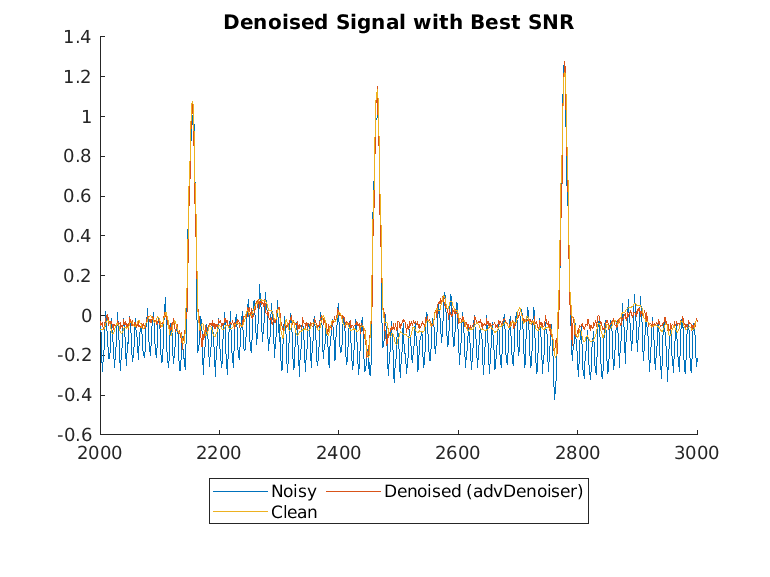


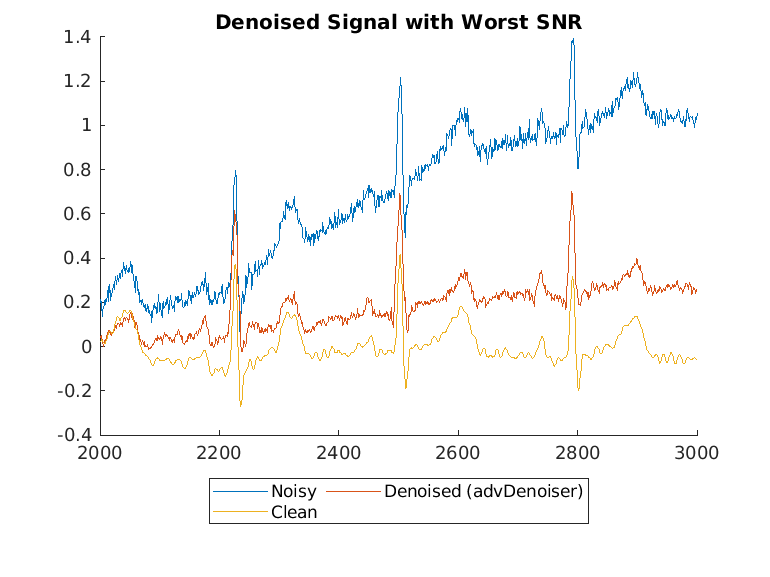

In [11]:
helperPlotDenoisedSignal(bestSNRIdx,worstSNRIdx,noisySignals,denoisedSignals,cleanSignals)

## Compare Results with Wavelet Denoising

A common question that arises when using deep learning approaches to solve signal processing problems is how these methods compare to classical or conventional signal processing techniques. Compare the performance of the adversarial learning model with a conventional wavelet denoising method. Use the wavelet denoising function [`wdenoise`](<docid:wavelet_ref#mw_c4196c2e-9915-4988-9c57-0295e056d602>) to denoise the test signals. The parameters in the example were obtained by the authors of the original paper [\[1\]](#M_ED167CE9) after an exhaustive search.


In [12]:
noisySignalsNormalized = noisySignals - mean(noisySignals,2);
waveletDenoisedSignals = wdenoise(double(noisySignalsNormalized),...
    Wavele = "sym8", ...
    ThresholdRule = "soft", ...
    NoiseEstimate = "LevelDependent");


Compute and visualize the SNR of the wavelet denoised signal.



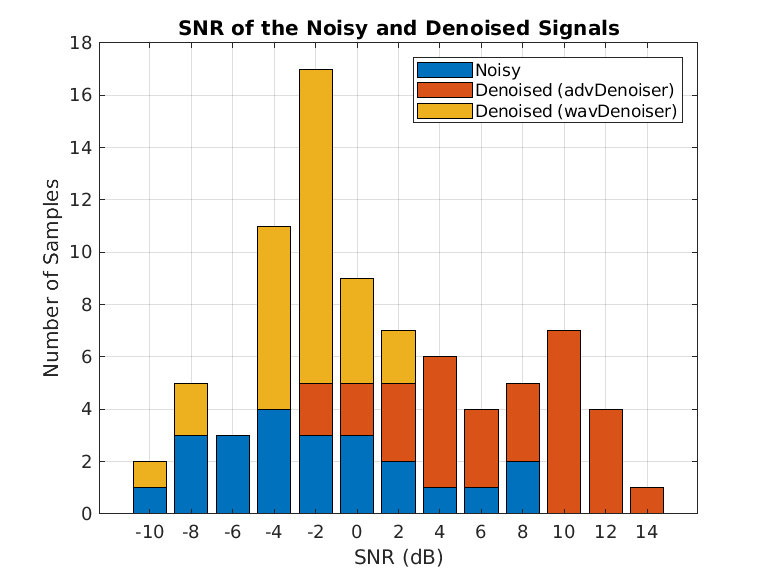

In [13]:
for i = 1:N
    snrsWaveletDenoised(i) = snr(cleanSignals(i,:),cleanSignals(i,:)-waveletDenoisedSignals(i,:));
end
SNRs = [snrsNoisy,snrsDenoised snrsWaveletDenoised];

bins = -10:2:16;
count = zeros(3,length(bins)-1);
for i =1:3
    count(i,:) = histcounts(SNRs(:,i),bins);
end
bar(bins(1:end-1),count,"stack");
legend(["Noisy","Denoised (advDenoiser)","Denoised (wavDenoiser)"],"Location","best")
title("SNR of the Noisy and Denoised Signals")
xlabel("SNR (dB)")
ylabel("Number of Samples")
grid on


Plot the wavelet\-denoised signal and the adversarial\-denoised signal for the worst SNR and best SNR.



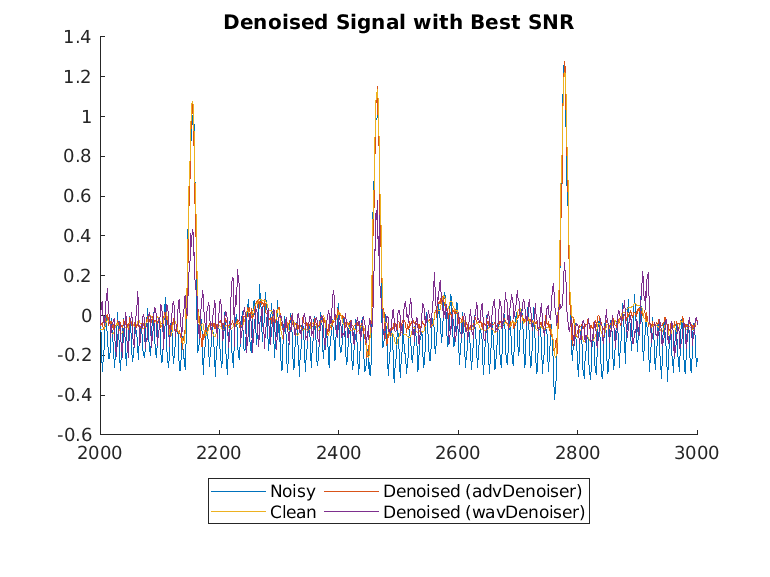


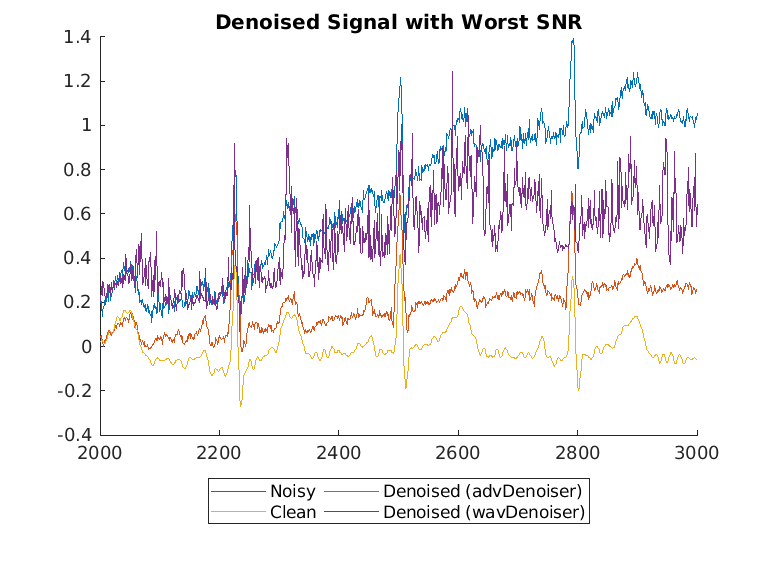

In [14]:
helperPlotDenoisedSignal(bestSNRIdx,worstSNRIdx,noisySignals,denoisedSignals,cleanSignals,waveletDenoisedSignals)


The adversarial denoiser performs better than the wavelet denoiser, especially for the worst SNR values.


Note that the clean signals used as the ground truth in this data set are manually filtered with a combination of some conventional noise reduction methods based on prior knowledge of the signal and noise. While these conventional methods can also work well to denoise signals, the adversarial denoiser model in this example does not require prior knowledge to apply signal denoising.

## Apply Denoiser Object to Different Data Set

You can train the adversarial learning signal denoiser object with many other data sets. For example, you can use the denoiser to denoise EEG signals.


To understand the performance of the adversarial signal denoiser, the model was compared with an LSTM network, `stftNet`, which uses short\-time Fourier transform (STFT) features as input. The adversarial denoiser object and stftNet were used to denoise EEG signals contaminated by EOG signals with different SNRs. For more information about stftNet and the EEG data set, see [Denoise EEG Signals Using Deep Learning Regression](<docid:signal_ug#mw_244a6a54-7255-4309-b5f0-feacc535fe94>).


The adversarial denoiser object and `stftNet` were trained with 10% of the original set of EEG signals. The plot illustrates the performance of the two models in terms of mean squared error. For comparison, the plot also shows the mean squared error of the original noisy signals without any denoising.

<p style="text-align:left">
   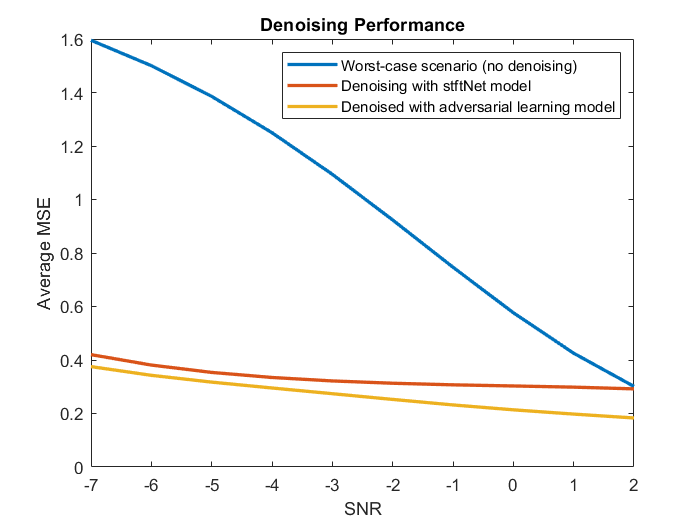
</p>


The adversarial model performs better than the `stftNet` model especially when the SNR is large.

## **References**
<a id="M_ED167CE9"></a>

\[1\] Casas, Leslie, Attila Klimmek, Nassir Navab, and Vasileios Belagiannis. “Adversarial Signal Denoising with Encoder\-Decoder Networks.” In 2020 28th European Signal Processing Conference (EUSIPCO), 1467–71. Amsterdam, Netherlands: IEEE, 2021. https://doi.org/10.23919/Eusipco47968.2020.9287738.

<a id="M_E2B4ED49"></a>

\[2\] Lugovaya, Tatiana. 2005. "Biometric Human Identification Based on Electrocardiogram." Master's thesis, Saint Petersburg Electrotechnical University.

<a id="M_5B899A74"></a>

\[3\] Goldberger, Ary L., Luis A. N. Amaral, Leon Glass, Jeffrey M. Hausdorff, Plamen Ch. Ivanov, Roger G. Mark, Joseph E. Mietus, George B. Moody, Chung\-Kang Peng, and H. Eugene Stanley. “PhysioBank, PhysioToolkit, and PhysioNet.” Circulation 101, no. 23 (June 13, 2000): e215–20. https://doi.org/10.1161/01.CIR.101.23.e215.


\[4\] Zhang, Haoming, Mingqi Zhao, Chen Wei, Dante Mantini, Zherui Li, and Quanying Liu. “EEGdenoiseNet: A Benchmark Dataset for End\-to\-End Deep Learning Solutions of EEG Denoising.” Preprint, submitted July 28, 2021. https://arxiv.org/abs/2009.11662.

##  **Appendix:** Helper Functions

In [15]:
function [dataOut,infoOut] = helperReadSignalData(filename)
    fid = fopen(filename,"r");
    % 1st row : raw data, 2nd row : filtered data
    data = fread(fid,[2 Inf],"int16=>single");
    fclose(fid);
    fid = fopen(replace(filename,".dat",".hea"),"r");
    header = textscan(fid,"%s%d%d%d",2,"Delimiter"," ");
    fclose(fid);
    gain = single(header{3}(2));
    dataOut{1} = data(1,:)/gain; % noisy, raw data
    dataOut{2} = data(2,:)/gain; % filtered, clean data
    infoOut.SampleRate = header{3}(1);
end

function helperPlotDenoisedSignal(varargin)
    bestSNRidx = varargin{1};
    worstSNRidx = varargin{2};
    plotRange = 2000:3000;
    labels = ["Noisy","Denoised (advDenoiser)","Clean","Denoised (wavDenoiser)"];

    figure
    hold on
    for i = 3:nargin
        signal = varargin{i};
        plot(plotRange,(signal(bestSNRidx,plotRange)));
    end


    legend(labels(1:nargin-2),Location="southoutside",Orientation = "horizontal",NumColumns=2)
    title("Denoised Signal with Best SNR")
    hold off

    figure
    hold on
    for i = 3:nargin
        signal = varargin{i};
        plot(plotRange,(signal(worstSNRidx,plotRange)));
    end
    legend(labels(1:nargin-2),Location="southoutside",Orientation = "horizontal",NumColumns=2)
    title("Denoised Signal with Worst SNR")
    hold off

end



Contains information from the  [PhysioNet ECG\-ID Database](https://physionet.org/content/ecgiddb/1.0.0/), which is made available under the ODC Attribution License available at [<u>https://opendatacommons.org/licenses/by/1\-0/</u>](https://opendatacommons.org/licenses/by/1-0/)<u>.</u>


Copyright 2021 The MathWorks, Inc.

